In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm, laplace, cauchy, multivariate_normal

np.random.seed(0)

from utils import traceplot, acfplot

# Generalised Normal Distribution

**Parameters:**

-   $\mu$: Location parameter.
-   $\alpha > 0$: Scale parameter.
-   $\beta > 0$: Shape parameter.

**PDF:**
$$f(x) \propto \exp \left\{- \left( \frac{|x - \mu|}{\alpha} \right)^\beta \right\}$$

**Log PDF:**
$$\log f(x) \propto - \left(\frac{|x - \mu|}{\alpha}\right)^\beta$$

**First derivative of log PDF:**
$$\frac{\text{d}}{\text{d} x} \log f(x) = -\frac{\beta}{\alpha} \left(\frac{|x - \mu|}{\alpha}\right)^{\beta - 1} \text{sgn}(x - \mu)$$

**Second derivative of log PDF:**
$$\frac{\text{d}^2}{\text{d} x^2} \log f(x) = -\frac{\beta (\beta - 1)}{\alpha^2} \left(\frac{|x - \mu|}{\alpha}\right)^{\beta - 2}$$

**Third derivative of log PDF:**
$$\frac{\text{d}^3}{\text{d} x^3} \log f(x) = - \frac{\beta (\beta - 1) (\beta - 2)}{\alpha^3} \left( \frac{|x - \mu|}{\alpha} \right)^{\beta - 3} \, \text{sgn}(x - \mu)$$


In [ ]:
def logpi_gnd(x, mu=0, alpha=1, beta=2):
    return - (np.abs(x - mu) / alpha)**beta

def grad_logpi_gnd(x, mu=0, alpha=1, beta=2):
    return - (beta / alpha) * (np.abs(x - mu) / alpha)**(beta - 1) * np.sign(x - mu)

def hess_logpi_gnd(x, mu=0, alpha=1, beta=2):
    return - (beta * (beta - 1) / alpha**2) * (np.abs(x - mu) / alpha)**(beta - 2)

def third_derivative_logpi_gnd(x, mu=0, alpha=1, beta=2):
    return - (beta * (beta - 1) * (beta - 2) / alpha**3) * (np.abs(x - mu) / alpha)**(beta - 3) * np.sign(x - mu)

# MALA


In [45]:
def mala_proposal(x, grad_logpi_x, step_size):
    z = step_size * np.random.normal(size=x.shape[0])

    return x + (step_size**2 /2) * grad_logpi_x + z


def mala_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, step_size):
    log_xy = norm.logpdf(y, loc=(x + (1/2) * (step_size**2) * grad_logpi_x), scale=(step_size**2))
    log_yx = norm.logpdf(x, loc=(y + (1/2) * (step_size**2) * grad_logpi_y), scale=(step_size**2))
    
    return log_yx - log_xy


def mala(n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # Matrix to store sampled values from chain (#components, #iterations)
    x_samples = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of target distribution at current state
    logpi_x = logpi_gnd(x, **kwargs)

    for i in range(n_iter):
        grad_logpi_x = grad_logpi_gnd(x, **kwargs)
        
        # Generate a proposal state
        y = mala_proposal(x, grad_logpi_x, step_size)
        logpi_y = logpi_gnd(y, **kwargs)
        grad_logpi_y = grad_logpi_gnd(y, **kwargs)

        # Calculate log preconditioned MALA acceptance rate
        log_acceptance = logpi_y - logpi_x + mala_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        # Store current state
        x_samples[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate

# MMALA


$$
y \sim \mathcal{N} \left(
    x + \frac{h}{2} A(x)) \nabla \log \pi(x) + h \Gamma(x),
    \ h A(x)
\right)
$$

$$A(x) = \frac{\text{d}^2}{\text{d} x^2} \log f(x)$$

$$\Gamma(x) = \frac{1}{2} \frac{\text{d}^3}{\text{d} x^3} \log f(x)$$


Acceptance rate:0.578


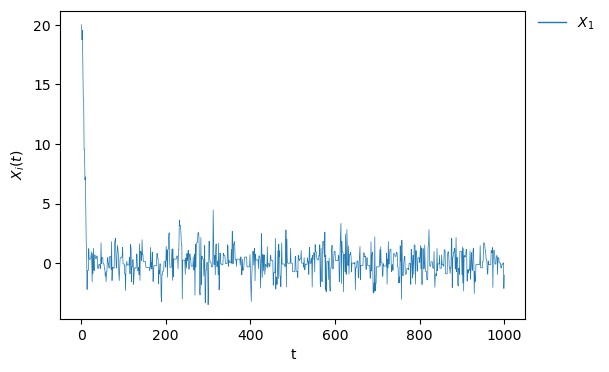

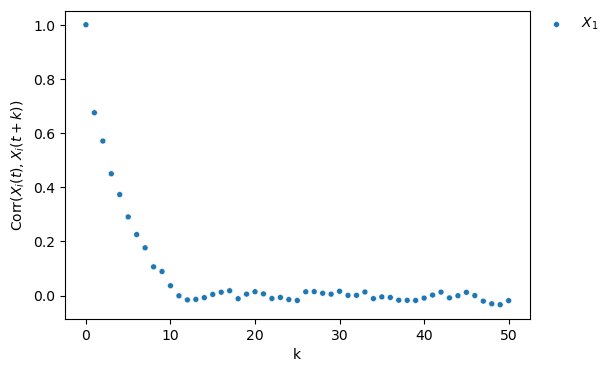

In [55]:
samples, accept_rate = mala(n_iter=1000, x_init=[20], beta=1, step_size=1.7)

print(f'Acceptance rate:{accept_rate}')

traceplot(samples)
acfplot(samples)